# Projet Final Kit Big Data
Guillaume SCOTTO

Imports

In [667]:
import pandas as pd
import datetime
from pathlib import Path
from bs4 import BeautifulSoup
import requests
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt

# Part I : Acquisition et chargement des données

In [666]:
Liste = ["210000","170000","140000","110000","080000","040000"]
range_date = pd.date_range(start='2020-11-09', end='2021-03-04')
range_date2 = pd.date_range(start='2020-11-09', end='2020-11-10',freq='D')
range_date

DatetimeIndex(['2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12',
               '2020-11-13', '2020-11-14', '2020-11-15', '2020-11-16',
               '2020-11-17', '2020-11-18',
               ...
               '2021-02-23', '2021-02-24', '2021-02-25', '2021-02-26',
               '2021-02-27', '2021-02-28', '2021-03-01', '2021-03-02',
               '2021-03-03', '2021-03-04'],
              dtype='datetime64[ns]', length=116, freq='D')

Download data

In [668]:
from shutil import copyfileobj
from urllib import request

Liste = ["210000","170000","140000","110000","080000","040000"]
range_date = pd.date_range(start='2020-11-09', end='2021-03-04')
range_date2 = pd.date_range(start='2020-11-09', end='2020-11-10',freq='D')
range_date

URLs = []
filename = []

for i in range_date:
    date = i.strftime('%Y%m%d')
    for i in Liste:
        URLs.append("https://www.vendeeglobe.org/download-race-data/vendeeglobe_"+date+"_"+i+".xlsx")
        filename.append(date+"_"+i+".xlsx")

for i in range(len(URLs)):
    print(URLs[i],filename[i])
    print(type(URLs[i]))
    #with request.urlopen(URLs[i]) as response, open(filename[i], 'wb') as out_file:
        #copyfileobj(response, out_file)


https://www.vendeeglobe.org/download-race-data/vendeeglobe_20201109_210000.xlsx 20201109_210000.xlsx
<class 'str'>
https://www.vendeeglobe.org/download-race-data/vendeeglobe_20201109_170000.xlsx 20201109_170000.xlsx
<class 'str'>
https://www.vendeeglobe.org/download-race-data/vendeeglobe_20201109_140000.xlsx 20201109_140000.xlsx
<class 'str'>
https://www.vendeeglobe.org/download-race-data/vendeeglobe_20201109_110000.xlsx 20201109_110000.xlsx
<class 'str'>
https://www.vendeeglobe.org/download-race-data/vendeeglobe_20201109_080000.xlsx 20201109_080000.xlsx
<class 'str'>
https://www.vendeeglobe.org/download-race-data/vendeeglobe_20201109_040000.xlsx 20201109_040000.xlsx
<class 'str'>
https://www.vendeeglobe.org/download-race-data/vendeeglobe_20201110_210000.xlsx 20201110_210000.xlsx
<class 'str'>
https://www.vendeeglobe.org/download-race-data/vendeeglobe_20201110_170000.xlsx 20201110_170000.xlsx
<class 'str'>
https://www.vendeeglobe.org/download-race-data/vendeeglobe_20201110_140000.xlsx 

# Fonctions de prétraitement

In [669]:
def extract_notarrived(df):
    """ Extrait du fichier source les compétiteurs encore en course
    Args:
        df (DataFrame): un tableau data avec tous les coureurs - arrivés ou pas
    Returns:
        df (DataFrame): preprocessed dataframe avec seuelement les compétiteurs encore en course
    """
    df = df.reset_index(drop=True)
    df.drop(['3','Unnamed: 1'], inplace=True, axis=1)
    df.drop(df.index[0:0], inplace=True)
    df = df.rename(columns={"Rang\r\nRank": "Rang"})
    df = df[df['Rang'].notna()]
    df = df[~df["Rang"].str.contains('[A-Za-z]')]
    return df

In [208]:
def extract_nationalite(df1):
    """ Extrait la nationalité
    Args:
        df (DataFrame): le tableau de donnees
    Returns:
        df (DataFrame): le tableau avec la colonne des nationalites
    """
    name= df1.columns[1]
    df1 = df1.rename(columns={name: "NatVoile"})
    df1['NatVoile'] = df1['NatVoile'].str.replace('\r', '').str.replace('\n', '')
    s = df1['NatVoile'].apply(lambda x: x.split()[0])
    df1.insert(1, 'Nationalité', s)
    s = df1['NatVoile'].apply(lambda x: x.split()[1])
    df1.insert(2, 'Voile', s)
    df1 = df1.drop(columns=['NatVoile'])
    return df1


In [670]:
def extract_skipper(df1):
    """ Extrait le skipper name
    Args:
        df (DataFrame): le tableau de donnees
    Returns:
        df (DataFrame): le tableau avec la colonne du nom du skipper
    """
    name= df1.columns[3]
    #df1 = df1.rename(columns={name: "SkipperBateau"})
    df1[name] = df1[name].str.replace('\r', '')
    s = df1[name].apply(lambda x: x.split("\n")[0])
    df1.insert(3, 'Skipper', s)
    s = df1[name].apply(lambda x: x.split("\n")[1])
    df1.insert(4, 'Bateau', s)
    df1 = df1.drop(columns=[name])
    return df1

In [542]:
def extract_reste(df1):
    """ Extrait les autres informations en changeant les noms de colonne
    Args:
        df (DataFrame): le tableau de donnees
    Returns:
        df (DataFrame): le tableau preprocessed
    """
    name= df1.columns[5]
    df1[name] = df1[name].str.replace('\r', '')
    s = df1[name].apply(lambda x: x.split()[0])
    df1.insert(5, 'Heure', s)
    df1 = df1.drop(columns=[name])
    df1 = df1.rename(columns={'Unnamed: 6': "Latitude", 'Unnamed: 7': "Longitude"})
    name= df1.columns[8:22]
    df1 = df1.rename(columns={name[0]: "Cap_30m",
                              name[1]: "Vitesse_30m",
                              name[2]: "VMG_30m",
                              name[3]: "Distance_30m",
                              name[4]: "Cap_last",
                              name[5]: "Vitesse_last",
                              name[6]: "VMG_last",
                              name[7]: "Distance_last",
                              name[8]: "Cap_24h",
                              name[9]: "Vitesse_24h",
                              name[10]: "VMG_24h",
                              name[11]: "Distance_24h",
                              name[10]: "VMG_24h",
                              name[11]: "Distance_24h",
                              name[12]: "DTF",
                              name[13]: "DTL"
                              })
    df1['Skipper'] = df1['Skipper'].str.upper()
    df1['Skipper'] = df1['Skipper'].str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')
    return df1

# Partie 2 : préparation des données

Extractions des données des bateaux

In [543]:
def extract_bateaux():
    """ Extract des infos des bateaux par scraping
    Args:
    Returns:
        df (DataFrame): un dataframe avec les informations des bateaux
    """
    soup = BeautifulSoup(requests.get('https://www.vendeeglobe.org/fr/glossaire').content)
    #On récupère le nom du skipper et du bateau
    infos_bateaux = soup.find_all('div', class_='boats-list__infos')
    Bateaux = []
    Skipper = []
    for i in infos_bateaux:
        Bateaux.append(i.find('h3').text)
        Skipper.append(i.find('span').text)
    #On récupère les autres infos et on remplit le dictionnaire
    List = []
    info = soup.find_all('div', class_='boats-list__popup-infos')
    for nmero, soup_boat_info in enumerate(info):
        boat_info = soup_boat_info.find_all('li')
        caracteristiques = [tuple(characteristics.text.split(' : ', maxsplit=1)) for characteristics in boat_info]
        dct = {}
        #print(boat_no)

        dct['Skipper']=Skipper[nmero]
        dct['Bateau']=Bateaux[nmero]
        for i in caracteristiques:
            dct[i[0]]=i[1]
        List.append(dct)
        final_List = []
        for i in List:
            new_dict = {key: val for key,
            val in i.items() if key != 'Anciens noms du bateau'}
            final_List.append(new_dict)
        df = pd.DataFrame(final_List)
        df['Skipper'] = df['Skipper'].str.upper()
        df['Skipper'] = df['Skipper'].str.normalize('NFKD').str.encode('ascii',errors='ignore').str.decode('utf-8')
        df = df.drop(['Bateau','Numéro de voile'],axis=1)
    return df

Merging les données des classements avec les donnees des bateaux

In [ ]:
def merging(df1,df2,file):
    """ Merging des informations de courses avec les infomations des bateaux
    Args:
        df1 (DataFrame) : dataframe des informations de course
        df2 (DataFrame) : dataframe des informations des bateaux
        file : nom du chemin
    Returns:
        df (DataFrame): un dataframe avec les informations des bateaux
    """
    df= pd.merge(left=df1,right=df2,on="Skipper",how="inner")
    tmp = re.findall('[0-9]+', file)[0]
    x = datetime.datetime(int(tmp[0:4]), int(tmp[4:6]), int(tmp[6:8]))
    df.insert(0, 'Date',x )
    return df

In [671]:
##GROSSE BOUCLE


def concat_all():
    """ Concat toutes les donnees des fichiers csv téléchargés
    Args:

    Returns:
        Rien
        mais enregistre le gros csv dans mon folder
    """
    path = "/Users/scotto/PycharmProjects/KitBigData/data"
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    onlyfiles.sort()
    myfilesList = onlyfiles[1:-5]

    df1 = pd.read_csv('data/'+myfilesList[0],header=4)
    df1 = extract_notarrived(df1)
    df1  = extract_nationalite(df1)
    df1 = extract_skipper(df1)
    df1 = extract_reste(df1)
    df2 = extract_bateaux()
    df = merging(df1,df2,myfilesList[0])

    for file in myfilesList[1:]:
        print(file)
        df1 = pd.read_csv('data/'+file,header=4)
        df1 = extract_notarrived(df1)
        df1  = extract_nationalite(df1)
        df1 = extract_skipper(df1)
        df1 = extract_reste(df1)
        df2 = extract_bateaux()
        df1 = merging(df1,df2,file)
        df = pd.concat([df, df1], ignore_index=True)


    filepath = Path('/Users/scotto/PycharmProjects/KitBigData/datafinal.csv')
    filepath.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(filepath)
    return None

Lecture de mon fichier global pour traitement

In [646]:
df = pd.read_csv("datafinal.csv")
print(df.shape)
df.head(5)

(14533, 36)


,Unnamed: 0,Date,Rang,Nationalité,Voile,Skipper,Bateau,Heure,Latitude,Longitude,...,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,0,2020-11-08,1,FRA,18,LOUIS BURTON,Bureau Vallée 2,15:30,46°24.46'N,01°50.48'W,...,09 Juin 2015,"18,28 m","5,80 m","4,50 m","7,6 t",foils,28 m,acier,300 m2,600 m2
1,1,2020-11-08,2,MON,10,BORIS HERRMANN,Seaexplorer - Yacht Club De Monaco,15:31,46°24.34'N,01°49.82'W,...,07 Août 2015,"18,28 m","5,70 m","4,50 m","7,6 t",foils,29 m,acier,290 m2,490 m2
2,2,2020-11-08,3,FRA,8,JEREMIE BEYOU,Charal,15:30,46°24.91'N,01°49.99'W,...,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2
3,3,2020-11-08,4,FRA,59,THOMAS RUYANT,LinkedOut,15:30,46°24.71'N,01°49.68'W,...,03 Septembre 2019,"18,28 m","5,85 m","4,50 m",8 t,foils,29 m,acier forgé,350 m2,560 m2
4,4,2020-11-08,5,FRA,53,MAXIME SOREL,V And B Mayenne,15:30,46°24.59'N,01°49.56'W,...,07 Septembre 2007,"18,28 m","5,50 m","4,50 m","7,7 t",2,29 m,acier,365 m2,700 m2


In [578]:
df["Skipper"].value_counts()

ARI HUUSELA             697
ALEXIA BARRIER          670
MANUEL COUSIN           622
MIRANDA MERRON          609
CLEMENT GIRAUD          599
DIDAC COSTA             584
PIP HARE                574
STEPHANE LE DIRAISON    573
KOJIRO SHIRAISHI        571
ARNAUD BOISSIERES       566
ROMAIN ATTANASIO        541
JEREMIE BEYOU           539
CLARISSE CREMER         523
ARMEL TRIPON            508
MAXIME SOREL            496
BENJAMIN DUTREUX        491
JEAN LE CAM             488
DAMIEN SEGUIN           486
GIANCARLO PEDOTE        486
BORIS HERRMANN          485
THOMAS RUYANT           484
LOUIS BURTON            483
YANNICK BESTAVEN        483
CHARLIE DALIN           481
SEBASTIEN DESTREMAU     417
ISABELLE JOSCHKE        376
FABRICE AMEDEO          200
SEBASTIEN SIMON         158
ALEX THOMSON            156
KEVIN ESCOFFIER         137
NICOLAS TROUSSEL         50
Name: Skipper, dtype: int64

Corrélation rang vitesse

In [647]:
df = pd.read_csv("datafinal.csv")
pattern = r'[0-9]+.[0-9]+'
s= "10.7 kts"
matches = re.findall(pattern,s)
df["VMG_last"] = df["VMG_last"].apply(lambda x : float(re.findall(pattern,x)[0]))
df_tmp = df[["Rang","Skipper","VMG_last"]].groupby("Skipper").mean(["Rang","Skipper"]).sort_values('Rang', ascending=True)
df_tmp.head(5)

,Rang,VMG_last
Skipper,,
CHARLIE DALIN,2.286902,12.780249
THOMAS RUYANT,3.524793,12.678099
YANNICK BESTAVEN,4.374741,12.723395
JEAN LE CAM,5.629098,12.559016
KEVIN ESCOFFIER,5.846715,12.259124


Nous pouvons observer que plus le rang baisse - ie le compétiteur est bien placé - plus la vitesse moyenne est élevée.
Il n'y a pourtant pas une corrélation nette qui s'explique par plusieurs facteurs :
- certains compétiteurs ont eu une compensation en gain de temps suite à une aide apportée à un concurrent ;
- certains compétiteurs n'ont pas pu finir la course pour diverses raisons, et ont pourtant eu un bon classement / bon rang pendant leur partie

Enfin puisque la course dure longtemps, il suffit d'un tout petit écart de vitesse pour faire une grande différence à la ligne d'arrivée

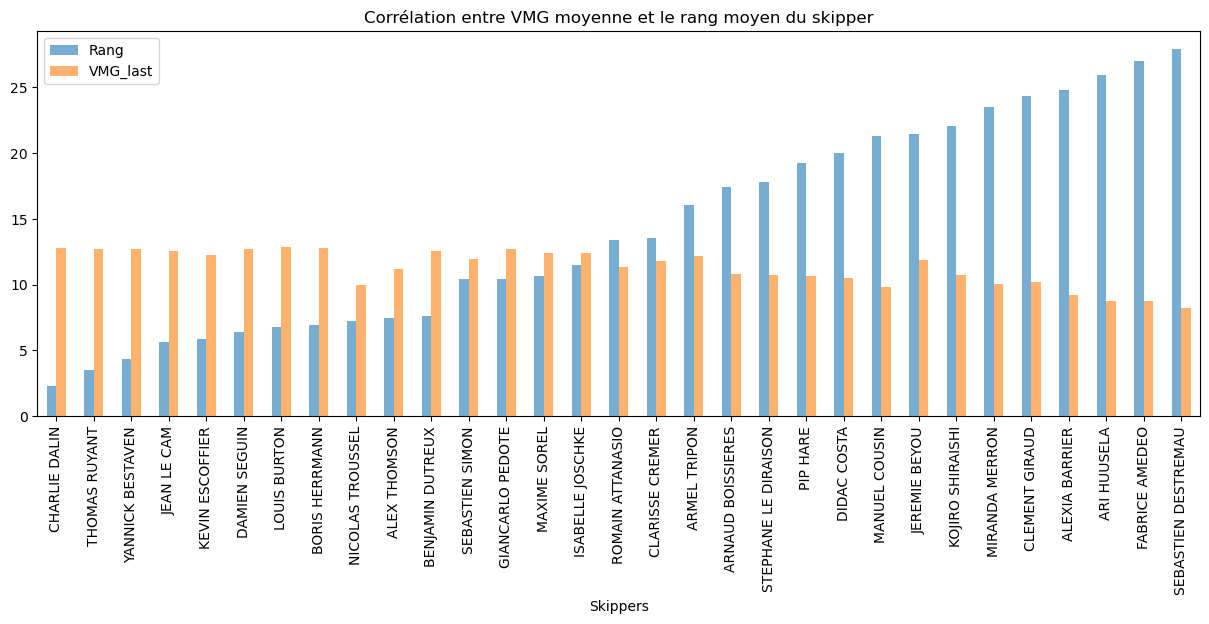

In [648]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df_tmp.plot.bar(ax=ax, alpha=0.6)
ax.set(xlabel='Skippers')
ax.set_title('Corrélation entre VMG moyenne et le rang moyen du skipper');

Corrélation vitesse foil rang

In [612]:
df.columns

Index(['Unnamed: 0', 'Date', 'Rang', 'Nationalité', 'Voile', 'Skipper',
       'Bateau', 'Heure', 'Latitude', 'Longitude', 'Cap_30m', 'Vitesse_30m',
       'VMG_30m', 'Distance_30m', 'Cap_last', 'Vitesse_last', 'VMG_last',
       'Distance_last', 'Cap_24h', 'Vitesse_24h', 'VMG_24h', 'Distance_24h',
       'DTF', 'DTL', 'Architecte', 'Chantier', 'Date de lancement', 'Longueur',
       'Largeur', 'Tirant d'eau', 'Déplacement (poids)', 'Nombre de dérives',
       'Hauteur mât', 'Voile quille', 'Surface de voiles au près',
       'Surface de voiles au portant'],
      dtype='object')

In [614]:
df["Nombre de dérives"].value_counts()

2                 7175
foils             6578
2 asymétriques     622
foiler             158
Name: Nombre de dérives, dtype: int64

In [672]:
#maping with int
dct = {'foils' : 1, '2':0, '2 asymétriques' : 0, 'foiler' : 1}
df['Nombre de dérives'] = df['Nombre de dérives'].replace(dct)
df

,Unnamed: 0,Date,Rang,Nationalité,Voile,Skipper,Bateau,Heure,Latitude,Longitude,...,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,0,2020-11-08,1,FRA,18,LOUIS BURTON,Bureau Vallée 2,15:30,46°24.46'N,01°50.48'W,...,09 Juin 2015,"18,28 m","5,80 m","4,50 m","7,6 t",1,28 m,acier,300 m2,600 m2
1,1,2020-11-08,2,MON,10,BORIS HERRMANN,Seaexplorer - Yacht Club De Monaco,15:31,46°24.34'N,01°49.82'W,...,07 Août 2015,"18,28 m","5,70 m","4,50 m","7,6 t",1,29 m,acier,290 m2,490 m2
2,2,2020-11-08,3,FRA,8,JEREMIE BEYOU,Charal,15:30,46°24.91'N,01°49.99'W,...,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,1,29 m,acier,320 m2,600 m2
3,3,2020-11-08,4,FRA,59,THOMAS RUYANT,LinkedOut,15:30,46°24.71'N,01°49.68'W,...,03 Septembre 2019,"18,28 m","5,85 m","4,50 m",8 t,1,29 m,acier forgé,350 m2,560 m2
4,4,2020-11-08,5,FRA,53,MAXIME SOREL,V And B Mayenne,15:30,46°24.59'N,01°49.56'W,...,07 Septembre 2007,"18,28 m","5,50 m","4,50 m","7,7 t",0,29 m,acier,365 m2,700 m2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14528,14528,2021-03-03,25,FIN,222,ARI HUUSELA,Stark,17:30,45°47.63'N,08°21.04'W,...,06 Août 2007,"18,28 m","5,80 m","4,50 m","8,5 t",0,28 m,acier,270 m2,580 m2
14529,14529,2021-03-03,25,FIN,222,ARI HUUSELA,Stark,21:30,45°59.48'N,07°36.19'W,...,06 Août 2007,"18,28 m","5,80 m","4,50 m","8,5 t",0,28 m,acier,270 m2,580 m2
14530,14530,2021-03-04,25,FIN,222,ARI HUUSELA,Stark,04:30,46°23.17'N,06°18.90'W,...,06 Août 2007,"18,28 m","5,80 m","4,50 m","8,5 t",0,28 m,acier,270 m2,580 m2
14531,14531,2021-03-04,25,FIN,222,ARI HUUSELA,Stark,08:30,46°49.09'N,05°50.61'W,...,06 Août 2007,"18,28 m","5,80 m","4,50 m","8,5 t",0,28 m,acier,270 m2,580 m2


In [657]:
df_tmp = df[["Rang","Skipper","VMG_last","Nombre de dérives" ]].groupby("Skipper").mean()
df_tmp

,Rang,VMG_last,Nombre de dérives
Skipper,,,
ALEX THOMSON,7.461538,11.152564,1.0
ALEXIA BARRIER,24.819403,9.220597,0.0
ARI HUUSELA,25.961263,8.735294,0.0
ARMEL TRIPON,16.076772,12.161614,1.0
ARNAUD BOISSIERES,17.452297,10.820848,1.0
BENJAMIN DUTREUX,7.572301,12.544196,0.0
BORIS HERRMANN,6.921649,12.779381,1.0
CHARLIE DALIN,2.286902,12.780249,1.0
CLARISSE CREMER,13.508604,11.796558,0.0


On peut observer que les compétiteurs équipé d'un foil (ici valeur 1.0) sur cette course ont eu un rang moyen meilleur
La vitesse moyenne est sensiblement meilleure pour ceux équipés d'un foil. Logique vu le graphe précédent

<AxesSubplot:xlabel='Nombre de dérives'>

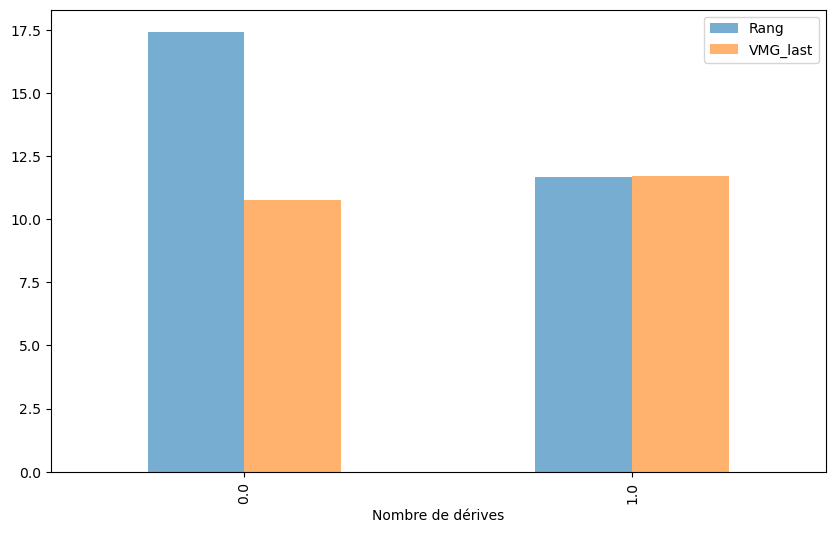

In [663]:
df_plt = df_tmp.groupby("Nombre de dérives").mean()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
df_plt.plot.bar(ax=ax, alpha=0.6)